This notebook simulates a selection of voxels that encode locations of a stimulus along a 1-dimensional feature space, and uses these information-carrying voxels to train and then test an inverted encoding model.

Written by David Huberdeau

In [1]:
import numpy as np
import brainiak.reconstruct.iem
import matplotlib.pyplot as plt

The following cell defines the feature space, defines voxel weights, and defines a function that allows for ready sampling of voxel activations based on a list of stimuli and a noise parameter.

The assumption in defining voxel weights is that each voxel has a preferred feature value, and that nearby feature values active that voxel according to a linear function of the distance of the feature to the voxel's preferred value. Thus, weights are assigned to each voxel so that one feature value (i.e. channel) is maximal (a weight value of 1) and other channels get a weight values that decreases linearly from 1 to 0. These voxel weights are assigned in a way so that each voxel has a different set of weights. 

In [2]:
# Define feature space, target locations, and basis functions
k_exponent = 4
feature_space = list(range(1, 150, 1))
targets = list(range(30, 121, 30))
basis_fcns = [[0]*len(feature_space)]*len(targets)
for i_func in range(0, len(targets)):
    x_ax = list(map(lambda x:x - targets[i_func], feature_space))
    this_fcn = list(map(lambda x:pow(x,k_exponent),
                         np.cos(np.deg2rad(x_ax))))
    basis_fcns[i_func] = this_fcn

# Define voxel weights for basis functions
n,w = 5,4 # n - defines dimensions of ROI (assumed an nxn square
# of voxels), w - number of weights
weight_fcn = np.linspace(0, 1, n)
voxel_def = []
roll_amt_1 = list(range(0, w))
roll_amt_2 = list(range(0, n))
for i_wt in range(0, w):
    this_wt_fcn = np.roll(weight_fcn, roll_amt_1[i_wt])
    this_voxel_list = []
    for i_vox1 in range(0, n):
        this_vox_fcn = list(np.roll(this_wt_fcn, roll_amt_2[i_vox1]))
        this_voxel_list.append(this_vox_fcn)
    voxel_def.append(this_voxel_list)

# define function that samples from voxels given the weights
def sample_voxel_activations(stimulus_list, s_noise):
    # function input:
        # stimulus_list - 1-dimensional list of stimulus categories
        # n - number of samples per stimulus desired
        # s_noise - the standard deviation of the gaussian noise
    voxel_sample = []
    for i_stim in range(0, len(stimulus_list)):
        for i_vox1 in range(0, n):
            for i_vox2 in range(0, n):
                voxel_sample.append(
                    voxel_def[stimulus_list[i_stim]][i_vox1][i_vox2]\
                    *basis_fcns[stimulus_list[i_stim]]\
                        [targets[stimulus_list[i_stim]]]\
                    + s_noise*np.random.normal())

    voxel_sample_out = \
        np.reshape(voxel_sample, (len(stimulus_list), n*n))
    return voxel_sample_out

In [3]:
# Simulate a sample of voxel activations for training:
s_noise = 0.1
n_samples_per_stim = 10
stimulus_list_ = np.matlib.repmat(list(range(0, w)), 1,
                                 n_samples_per_stim)
stim_list_train = stimulus_list_[0]
voxel_sample_train = sample_voxel_activations(
    stim_list_train, s_noise)

stim_direction_train = []
for i_stim in range(0,len(stim_list_train)):
    stim_direction_train.append(targets[stim_list_train[i_stim]])



In [4]:
# Create model and train:
Invt_model = brainiak.reconstruct.iem.InvertedEncoding(4, 4, 0, 150)
_ = Invt_model.fit(voxel_sample_train, stim_direction_train)

In [5]:
# Simulate a sample of voxel activations for testing:
s_noise = 0.1
n_samples_per_stim = 10
stimulus_list_ = np.matlib.repmat(list(range(0, w)), 1,
                                 n_samples_per_stim)
stim_list_test = stimulus_list_[0]
voxel_sample_test = sample_voxel_activations(
    stim_list_train, s_noise)

stim_direction_test = []
for i_stim in range(0, len(stim_list_test)):
    stim_direction_test.append(targets[stim_list_test[i_stim]])


The following cell computes a prediction of the feature value given a new sampling of voxel activations using the predict() function. A score for that prediction can also be obtained using the score() function, where the predicted feature values are compared to actual feature values that were presented to obtain those voxel activations.

In [6]:
# Test reconstruction with simulated test voxels:
s_predict = Invt_model.predict(voxel_sample_test)
score = Invt_model.score(voxel_sample_test, stim_direction_test)

In [7]:
s_predict

array([ 32.68156425,  62.84916201,  87.15083799, 114.80446927,
        31.84357542,  64.52513966,  89.66480447, 117.31843575,
        32.68156425,  62.01117318,  87.15083799, 118.99441341,
        31.84357542,  64.52513966,  87.15083799, 117.31843575,
        34.3575419 ,  63.68715084,  86.31284916, 118.99441341,
        31.00558659,  61.17318436,  87.15083799, 116.48044693,
        31.84357542,  62.84916201,  89.66480447, 118.15642458,
        32.68156425,  62.84916201,  87.98882682, 118.15642458,
        33.51955307,  59.4972067 ,  88.82681564, 117.31843575,
        33.51955307,  66.20111732,  87.98882682, 119.83240223])

In [8]:
# show score
score

0.9927748821822041

A reconstruction of the representation under the model can be obtained that amounts to the sum of the basis functions for a given stimulus. This is obtained by computing the estimated channel responses, then applying those responses to each channel for every trial. The resultant representation of basis functions can be visualized by plotting it as a function of the feature space. The peak of this representation corresponds to the predicted stimulus value. 

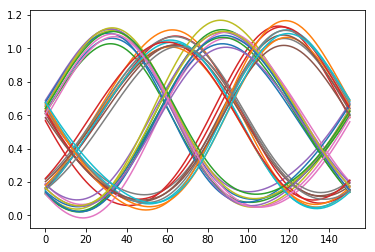

In [9]:
# plot the reconstructed basis function representations:
d_predict = Invt_model._predict_direction_responses(voxel_sample_test)
f_space = Invt_model.C_D_
_ = plt.plot(f_space, d_predict)

The following cell computes the mean representation for a given feature value. The computation does not rely on known feature values for each trial, and instead computes the mean among trials with the same classified feature value. 

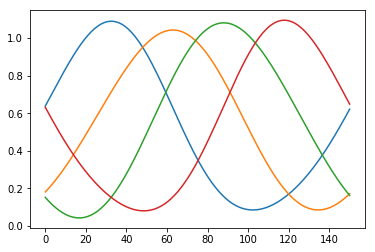

In [10]:
# plot mean reconstructions for each category

cat_predict = []
for i_tr in range(0,len(s_predict)):
    targ_dist = np.abs(s_predict[i_tr] - targets)
    targ_match = np.argmin(targ_dist)
    cat_predict.append(targets[targ_match])

for i_cat in range(0, len(targets)):
    d_cat = [d_predict[:,x] for x in range(0, len(cat_predict))
             if cat_predict[x] == targets[i_cat]]
    d_cat2 = np.array(d_cat)
    _ = plt.plot(f_space, np.mean(d_cat,0))